In [6]:
from PIL import Image
#from cityscapesscripts.helpers import labels
from cityscapesscripts.helpers import labels as cs_labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from backbones_unet.model.unet import Unet
from torchvision.datasets import Cityscapes


# Setup

In [7]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

from contextlib import contextmanager
import ssl
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context

batch_size = 8  
NUM_CLASSES = 19
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

Seeds set for reproducibility is 42
mps


In [8]:
def cityscapes_mask_to_train_ids(mask):
    mask_np = np.array(mask)
    labels_mapping = {label.id: label.trainId for label in cs_labels.labels if label.trainId != -1}
    labels_mapping[-1] = 255  # Map invalid labels to 255
    mask_np = np.vectorize(labels_mapping.get)(mask_np)
    mask_np = np.where(mask_np <= 18, mask_np, 255).astype(np.uint8)  # Ensure that all pixels are within the range of train IDs
    return torch.from_numpy(mask_np).long()


path_images = "syn_resized_images"
path_target = "syn_resized_gt"

unet_image_transform = transforms.Compose([
    transforms.Resize((256, 480)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

unet_target_transform = transforms.Compose([
    transforms.Resize((256, 480), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: cityscapes_mask_to_train_ids(x))
])

deeplab_image_transform = transforms.Compose([
    transforms.Resize((256, 466)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

deeplab_target_transform = transforms.Compose([
    transforms.Resize((256, 466), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: cityscapes_mask_to_train_ids(x))
])

unet_real_val_dataset = Cityscapes(
    root='cityscapes',
    split='val',
    mode='fine',
    target_type='semantic',
    transform=unet_image_transform,
    target_transform=unet_target_transform
)

unet_real_test_dataset = Cityscapes(
    root='cityscapes',
    split='test',
    mode='fine',
    target_type='semantic',
    transform=unet_image_transform,
    target_transform=unet_target_transform
)

deeplab_real_val_dataset = Cityscapes(
    root='cityscapes',
    split='val',
    mode='fine',
    target_type='semantic',
    transform=deeplab_image_transform,
    target_transform=deeplab_target_transform
)

deeplab_real_test_dataset = Cityscapes(
    root='cityscapes',
    split='test',
    mode='fine',
    target_type='semantic',
    transform=deeplab_image_transform,
    target_transform=deeplab_target_transform
)

unet_real_val_dataloader = DataLoader(
    unet_real_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

deeplab_real_val_dataloader = DataLoader(
    deeplab_real_val_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

unet_real_test_dataloader = DataLoader(
    unet_real_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

deeplab_real_test_dataloader = DataLoader(
    deeplab_real_test_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

In [9]:
def visualize_deeplab_unet_comparison(deeplab_sup_model, deeplab_unsup_model, unet_sup_model, unet_unsup_model,
                                  deeplab_dataloader, unet_dataloader,
                                  num_samples=4, start_idx=0, deterministic=False,
                                  confidence_threshold=0.5, entropy_threshold=1.0, method='combined'):
    """
    Visualize and compare segmentation results between 4 models: 2 DeepLab and 2 U-Net models
    
    Args:
        deeplab_sup_model: DeepLab supervised model (best target val IoU)
        deeplab_unsup_model: DeepLab unsupervised model (best source val IoU)
        unet_sup_model: U-Net supervised model (best target val IoU)
        unet_unsup_model: U-Net unsupervised model (best source val IoU)
        deeplab_dataloader: DataLoader for DeepLab models (with their specific image size)
        unet_dataloader: DataLoader for U-Net models (with their specific image size)
        num_samples: Number of samples to visualize
        start_idx: Starting index for deterministic sampling
        deterministic: If True, select images deterministically by index
        confidence_threshold: Minimum confidence for non-background classification
        entropy_threshold: Maximum entropy for non-background classification
        method: Background detection method ('entropy', 'confidence', 'combined')
    """
    # Set all models to evaluation mode
    deeplab_sup_model.eval()
    deeplab_unsup_model.eval()
    unet_sup_model.eval()
    unet_unsup_model.eval()
    
    def get_samples_from_dataloader(dataloader, num_samples, start_idx, deterministic):
        """Helper function to extract samples from a dataloader"""
        if deterministic:
            dataset = dataloader.dataset
            
            if hasattr(dataset, 'dataset') and hasattr(dataset, 'indices'):
                # Handle Subset dataset
                orig_dataset = dataset.dataset
                indices = dataset.indices
                selected_indices = indices[start_idx:start_idx + num_samples]
                
                images = []
                targets = []
                for idx in selected_indices:
                    img, tgt = orig_dataset[idx]
                    images.append(img.unsqueeze(0))
                    targets.append(tgt.unsqueeze(0))
                
                images = torch.cat(images, dim=0)
                targets = torch.cat(targets, dim=0)
            else:
                # Handle regular dataset
                images = []
                targets = []
                for i in range(start_idx, min(start_idx + num_samples, len(dataset))):
                    img, tgt = dataset[i]
                    images.append(img.unsqueeze(0))
                    targets.append(tgt.unsqueeze(0))
                
                images = torch.cat(images, dim=0)
                targets = torch.cat(targets, dim=0)
        else:
            # Random sampling
            images, targets = next(iter(dataloader))
            images = images[:num_samples]
            targets = targets[:num_samples]
        
        return images[:num_samples], targets[:num_samples]
    
    # Get samples from both dataloaders
    deeplab_images, deeplab_targets = get_samples_from_dataloader(
        deeplab_dataloader, num_samples, start_idx, deterministic
    )
    unet_images, unet_targets = get_samples_from_dataloader(
        unet_dataloader, num_samples, start_idx, deterministic
    )
    
    # Move to device
    deeplab_images = deeplab_images.to(DEVICE)
    deeplab_targets = deeplab_targets.to(DEVICE)
    unet_images = unet_images.to(DEVICE)
    unet_targets = unet_targets.to(DEVICE)
    
    # Process all models
    with torch.no_grad():
        # DeepLab Supervised predictions
        deeplab_sup_outputs = deeplab_sup_model(deeplab_images)
        if isinstance(deeplab_sup_outputs, dict) and 'out' in deeplab_sup_outputs:
            deeplab_sup_outputs = deeplab_sup_outputs['out']
        
        deeplab_sup_probabilities = F.softmax(deeplab_sup_outputs, dim=1)
        deeplab_sup_max_probs, deeplab_sup_predictions = torch.max(deeplab_sup_probabilities, dim=1)
        deeplab_sup_entropy = -torch.sum(deeplab_sup_probabilities * torch.log(deeplab_sup_probabilities + 1e-8), dim=1)
        
        # DeepLab Unsupervised predictions
        deeplab_unsup_outputs = deeplab_unsup_model(deeplab_images)
        if isinstance(deeplab_unsup_outputs, dict) and 'out' in deeplab_unsup_outputs:
            deeplab_unsup_outputs = deeplab_unsup_outputs['out']
        
        deeplab_unsup_probabilities = F.softmax(deeplab_unsup_outputs, dim=1)
        deeplab_unsup_max_probs, deeplab_unsup_predictions = torch.max(deeplab_unsup_probabilities, dim=1)
        deeplab_unsup_entropy = -torch.sum(deeplab_unsup_probabilities * torch.log(deeplab_unsup_probabilities + 1e-8), dim=1)
        
        # U-Net Supervised predictions
        unet_sup_outputs = unet_sup_model(unet_images)
        if isinstance(unet_sup_outputs, dict) and 'out' in unet_sup_outputs:
            unet_sup_outputs = unet_sup_outputs['out']
        
        unet_sup_probabilities = F.softmax(unet_sup_outputs, dim=1)
        unet_sup_max_probs, unet_sup_predictions = torch.max(unet_sup_probabilities, dim=1)
        unet_sup_entropy = -torch.sum(unet_sup_probabilities * torch.log(unet_sup_probabilities + 1e-8), dim=1)
        
        # U-Net Unsupervised predictions
        unet_unsup_outputs = unet_unsup_model(unet_images)
        if isinstance(unet_unsup_outputs, dict) and 'out' in unet_unsup_outputs:
            unet_unsup_outputs = unet_unsup_outputs['out']
        
        unet_unsup_probabilities = F.softmax(unet_unsup_outputs, dim=1)
        unet_unsup_max_probs, unet_unsup_predictions = torch.max(unet_unsup_probabilities, dim=1)
        unet_unsup_entropy = -torch.sum(unet_unsup_probabilities * torch.log(unet_unsup_probabilities + 1e-8), dim=1)
        
        # Apply background detection for all models
        def get_background_mask(max_probs, entropy, method):
            if method == 'confidence':
                return max_probs < confidence_threshold
            elif method == 'entropy':
                return entropy > entropy_threshold
            elif method == 'combined':
                return (max_probs < confidence_threshold) | (entropy > entropy_threshold)
            else:
                return torch.zeros_like(max_probs, dtype=torch.bool)
        
        # Background masks for all models
        deeplab_sup_bg_mask = get_background_mask(deeplab_sup_max_probs, deeplab_sup_entropy, method)
        deeplab_unsup_bg_mask = get_background_mask(deeplab_unsup_max_probs, deeplab_unsup_entropy, method)
        unet_sup_bg_mask = get_background_mask(unet_sup_max_probs, unet_sup_entropy, method)
        unet_unsup_bg_mask = get_background_mask(unet_unsup_max_probs, unet_unsup_entropy, method)
        
        # Create predictions with background for all models
        deeplab_sup_pred_with_bg = deeplab_sup_predictions.clone()
        deeplab_sup_pred_with_bg[deeplab_sup_bg_mask] = 255
        
        deeplab_unsup_pred_with_bg = deeplab_unsup_predictions.clone()
        deeplab_unsup_pred_with_bg[deeplab_unsup_bg_mask] = 255
        
        unet_sup_pred_with_bg = unet_sup_predictions.clone()
        unet_sup_pred_with_bg[unet_sup_bg_mask] = 255
        
        unet_unsup_pred_with_bg = unet_unsup_predictions.clone()
        unet_unsup_pred_with_bg[unet_unsup_bg_mask] = 255
    
    # Move all to CPU for visualization
    deeplab_images = deeplab_images.cpu()
    deeplab_targets = deeplab_targets.cpu()
    deeplab_sup_pred_with_bg = deeplab_sup_pred_with_bg.cpu()
    deeplab_unsup_pred_with_bg = deeplab_unsup_pred_with_bg.cpu()
    
    unet_images = unet_images.cpu()
    unet_targets = unet_targets.cpu()
    unet_sup_pred_with_bg = unet_sup_pred_with_bg.cpu()
    unet_unsup_pred_with_bg = unet_unsup_pred_with_bg.cpu()
    
    def apply_color_map_with_background(seg_map):
        """Apply color mapping to segmentation map with black background"""
        colored_map = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
        
        # Get valid labels (excluding ignore classes)
        valid_labels = [label for label in cs_labels.labels if label.trainId != 255 and label.trainId != -1]
        
        for label in valid_labels:
            mask = seg_map == label.trainId
            colored_map[mask] = label.color
        
        # Background pixels remain black (0, 0, 0)
        return colored_map
    
    def normalize_image(img_tensor):
        """Normalize image tensor for display"""
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        return img
    
    # Plot results with 6 columns: 
    # Original Image - GT - DeepLab Sup w/BG - DeepLab Unsup w/BG - U-Net Sup w/BG - U-Net Unsup w/BG
    fig, axes = plt.subplots(num_samples, 6, figsize=(30, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(deeplab_images))):
        # Original image (from DeepLab for display)
        deeplab_img = normalize_image(deeplab_images[i])
        axes[i, 0].imshow(deeplab_img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Ground truth (use deeplab_targets for display)
        gt_colored = apply_color_map_with_background(deeplab_targets[i].numpy())
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # DeepLab supervised with background
        deeplab_sup_pred_bg_colored = apply_color_map_with_background(deeplab_sup_pred_with_bg[i].numpy())
        axes[i, 2].imshow(deeplab_sup_pred_bg_colored)
        axes[i, 2].set_title(f'DeepLab Sup\nw/ BG ({method})')
        axes[i, 2].axis('off')
        
        # DeepLab unsupervised with background
        deeplab_unsup_pred_bg_colored = apply_color_map_with_background(deeplab_unsup_pred_with_bg[i].numpy())
        axes[i, 3].imshow(deeplab_unsup_pred_bg_colored)
        axes[i, 3].set_title(f'DeepLab Unsup\nw/ BG ({method})')
        axes[i, 3].axis('off')
        
        # U-Net supervised with background
        unet_sup_pred_bg_colored = apply_color_map_with_background(unet_sup_pred_with_bg[i].numpy())
        axes[i, 4].imshow(unet_sup_pred_bg_colored)
        axes[i, 4].set_title(f'U-Net Sup\nw/ BG ({method})')
        axes[i, 4].axis('off')
        
        # U-Net unsupervised with background
        unet_unsup_pred_bg_colored = apply_color_map_with_background(unet_unsup_pred_with_bg[i].numpy())
        axes[i, 5].imshow(unet_unsup_pred_bg_colored)
        axes[i, 5].set_title(f'U-Net Unsup\nw/ BG ({method})')
        axes[i, 5].axis('off')
    
    plt.suptitle('Model Comparison: All Models with Background Detection', fontsize=18, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed information
    print(f"Input sizes - DeepLab: {deeplab_images.shape[2:]} | U-Net: {unet_images.shape[2:]} (H x W)")
    print(f"Background detection method: {method}")
    print(f"Confidence threshold: {confidence_threshold}")
    print(f"Entropy threshold: {entropy_threshold}")

In [10]:
# Load all 4 models for comparison based on specific requirements

# 1. DeepLab best supervised - DA_deeplabv3 (best supervised)
print("Loading DeepLab best supervised Model (DA_deeplabv3 best supervised)...") # target val IoU 0,3010
if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model_deeplab_sup = deeplabv3_resnet50(
            weights='COCO_WITH_VOC_LABELS_V1', 
            weights_backbone='IMAGENET1K_V1'
        )
else:
    model_deeplab_sup = deeplabv3_resnet50(
        weights='COCO_WITH_VOC_LABELS_V1', 
        weights_backbone='IMAGENET1K_V1'
    )

model_deeplab_sup.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model_deeplab_sup = model_deeplab_sup.to(DEVICE)

best_model_path = "models/DA_lowerMMD_deeplabv3_imagenet1k_multilevelmmd_best_supervised_model.pth"
print(f"Loading DeepLab supervised model from: {best_model_path}")
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model_deeplab_sup.load_state_dict(checkpoint['model_state_dict'])
print(f"DeepLab supervised model loaded successfully!")
print(f"Training epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Target validation IoU: {checkpoint.get('target_val_avg_iou', 'N/A'):.4f}")
print(f"Source validation IoU: {checkpoint.get('source_val_avg_iou', 'N/A'):.4f}")

# Store metrics for summary
deeplab_sup_epoch = checkpoint.get('epoch', 'N/A')
deeplab_sup_target_iou = checkpoint.get('target_val_avg_iou', 0.0)
deeplab_sup_source_iou = checkpoint.get('source_val_avg_iou', 0.0)

print("--"*20)

# 2. DeepLab best unsupervised - DA_minMMD (best unsupervised)
print("Loading DeepLab best unsupervised Model (DA_minMMD best unsupervised)...") # source val Iou 0,5474
if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model_deeplab_unsup = deeplabv3_resnet50(
            weights='COCO_WITH_VOC_LABELS_V1', 
            weights_backbone='IMAGENET1K_V1'
        )
else:
    model_deeplab_unsup = deeplabv3_resnet50(
        weights='COCO_WITH_VOC_LABELS_V1', 
        weights_backbone='IMAGENET1K_V1'
    )

model_deeplab_unsup.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model_deeplab_unsup = model_deeplab_unsup.to(DEVICE)

best_model_path = "models/DA_lowerMMD_deeplabv3_imagenet1k_multilevelmmd_best_unsupervised_model.pth"
print(f"Loading DeepLab unsupervised model from: {best_model_path}")
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model_deeplab_unsup.load_state_dict(checkpoint['model_state_dict'])
print(f"DeepLab unsupervised model loaded successfully!")
print(f"Training epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Source validation IoU: {checkpoint.get('source_val_avg_iou', 'N/A'):.4f}")
print(f"Target validation IoU: {checkpoint.get('target_val_avg_iou', 'N/A'):.4f}")

# Store metrics for summary
deeplab_unsup_epoch = checkpoint.get('epoch', 'N/A')
deeplab_unsup_source_iou = checkpoint.get('source_val_avg_iou', 0.0)
deeplab_unsup_target_iou = checkpoint.get('target_val_avg_iou', 0.0)

print("--"*20)

# 3. U-Net best supervised - DA_lowerMMD (best supervised)  # target val IoU 0,3063
print("Loading U-Net best supervised Model (DA_lowerMMD best supervised)...")
if DEVICE.type == 'mps':
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model_unet_sup = Unet(
            backbone='resnet50',
            pretrained=True,
            in_channels=3,
            num_classes=NUM_CLASSES,
        )
else:
    model_unet_sup = Unet(
        backbone='resnet50',
        pretrained=True,
        in_channels=3,
        num_classes=NUM_CLASSES,
    )

model_unet_sup = model_unet_sup.to(DEVICE)

best_model_path = "models/DA_lowerMMD_unet_imagenet1k_480x256_best_supervised_model.pth"
print(f"Loading U-Net supervised model from: {best_model_path}")
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model_unet_sup.load_state_dict(checkpoint['model_state_dict'])
print(f"U-Net supervised model loaded successfully!")
print(f"Training epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Target validation IoU: {checkpoint.get('target_val_avg_iou', 'N/A'):.4f}")
print(f"Source validation IoU: {checkpoint.get('source_val_avg_iou', 'N/A'):.4f}")

# Store metrics for summary
unet_sup_epoch = checkpoint.get('epoch', 'N/A')
unet_sup_target_iou = checkpoint.get('target_val_avg_iou', 0.0)
unet_sup_source_iou = checkpoint.get('source_val_avg_iou', 0.0)

print("--"*20)

# 4. U-Net best unsupervised - DA_minMMD (best unsupervised) source val IoU 0.5644
print("Loading U-Net best unsupervised Model (DA_minMMD best unsupervised)...")
if DEVICE.type == 'mps':
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model_unet_unsup = Unet(
            backbone='resnet50',
            pretrained=True,
            in_channels=3,
            num_classes=NUM_CLASSES,
        )
else:
    model_unet_unsup = Unet(
        backbone='resnet50',
        pretrained=True,
        in_channels=3,
        num_classes=NUM_CLASSES,
    )

model_unet_unsup = model_unet_unsup.to(DEVICE)

best_model_path = "models/DA_minMMD_unet_imagenet1k_480x256_best_unsupervised_model.pth"
print(f"Loading U-Net unsupervised model from: {best_model_path}")
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model_unet_unsup.load_state_dict(checkpoint['model_state_dict'])
print(f"U-Net unsupervised model loaded successfully!")
print(f"Training epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Source validation IoU: {checkpoint.get('source_val_avg_iou', 'N/A'):.4f}")
print(f"Target validation IoU: {checkpoint.get('target_val_avg_iou', 'N/A'):.4f}")

# Store metrics for summary
unet_unsup_epoch = checkpoint.get('epoch', 'N/A')
unet_unsup_source_iou = checkpoint.get('source_val_avg_iou', 0.0)
unet_unsup_target_iou = checkpoint.get('target_val_avg_iou', 0.0)

print("="*50)
print("All 4 models loaded successfully!")
print("\nModel Performance Summary:")
print("DeepLab Models:")
print(f"  - Supervised (DA_deeplabv3): Target IoU {deeplab_sup_target_iou:.4f} | Source IoU {deeplab_sup_source_iou:.4f} (Epoch {deeplab_sup_epoch})")
print(f"  - Unsupervised (DA_minMMD): Source IoU {deeplab_unsup_source_iou:.4f} | Target IoU {deeplab_unsup_target_iou:.4f} (Epoch {deeplab_unsup_epoch})")
print("U-Net Models:")
print(f"  - Supervised (DA_lowerMMD): Target IoU {unet_sup_target_iou:.4f} | Source IoU {unet_sup_source_iou:.4f} (Epoch {unet_sup_epoch})")
print(f"  - Unsupervised (DA_minMMD): Source IoU {unet_unsup_source_iou:.4f} | Target IoU {unet_unsup_target_iou:.4f} (Epoch {unet_unsup_epoch})")

print("\nModels ready for comparison!")
print("Available models:")
print(f"- model_deeplab_sup: DeepLab supervised (Target IoU: {deeplab_sup_target_iou:.4f})")
print(f"- model_deeplab_unsup: DeepLab unsupervised (Source IoU: {deeplab_unsup_source_iou:.4f})")
print(f"- model_unet_sup: U-Net supervised (Target IoU: {unet_sup_target_iou:.4f})")
print(f"- model_unet_unsup: U-Net unsupervised (Source IoU: {unet_unsup_source_iou:.4f})")

# Clean up checkpoint variable to free memory
del checkpoint


Loading DeepLab best supervised Model (DA_deeplabv3 best supervised)...
mps detected, using no_ssl_verification
Loading DeepLab supervised model from: models/DA_lowerMMD_deeplabv3_imagenet1k_multilevelmmd_best_supervised_model.pth
DeepLab supervised model loaded successfully!
Training epoch: 1
Target validation IoU: 0.3093
Source validation IoU: 0.5307
----------------------------------------
Loading DeepLab best unsupervised Model (DA_minMMD best unsupervised)...
mps detected, using no_ssl_verification
Loading DeepLab unsupervised model from: models/DA_lowerMMD_deeplabv3_imagenet1k_multilevelmmd_best_unsupervised_model.pth
DeepLab unsupervised model loaded successfully!
Training epoch: 8
Source validation IoU: 0.5531
Target validation IoU: 0.2990
----------------------------------------
Loading U-Net best supervised Model (DA_lowerMMD best supervised)...
mps detected, using no_ssl_verification
Loading U-Net supervised model from: models/DA_lowerMMD_unet_imagenet1k_480x256_best_supervi

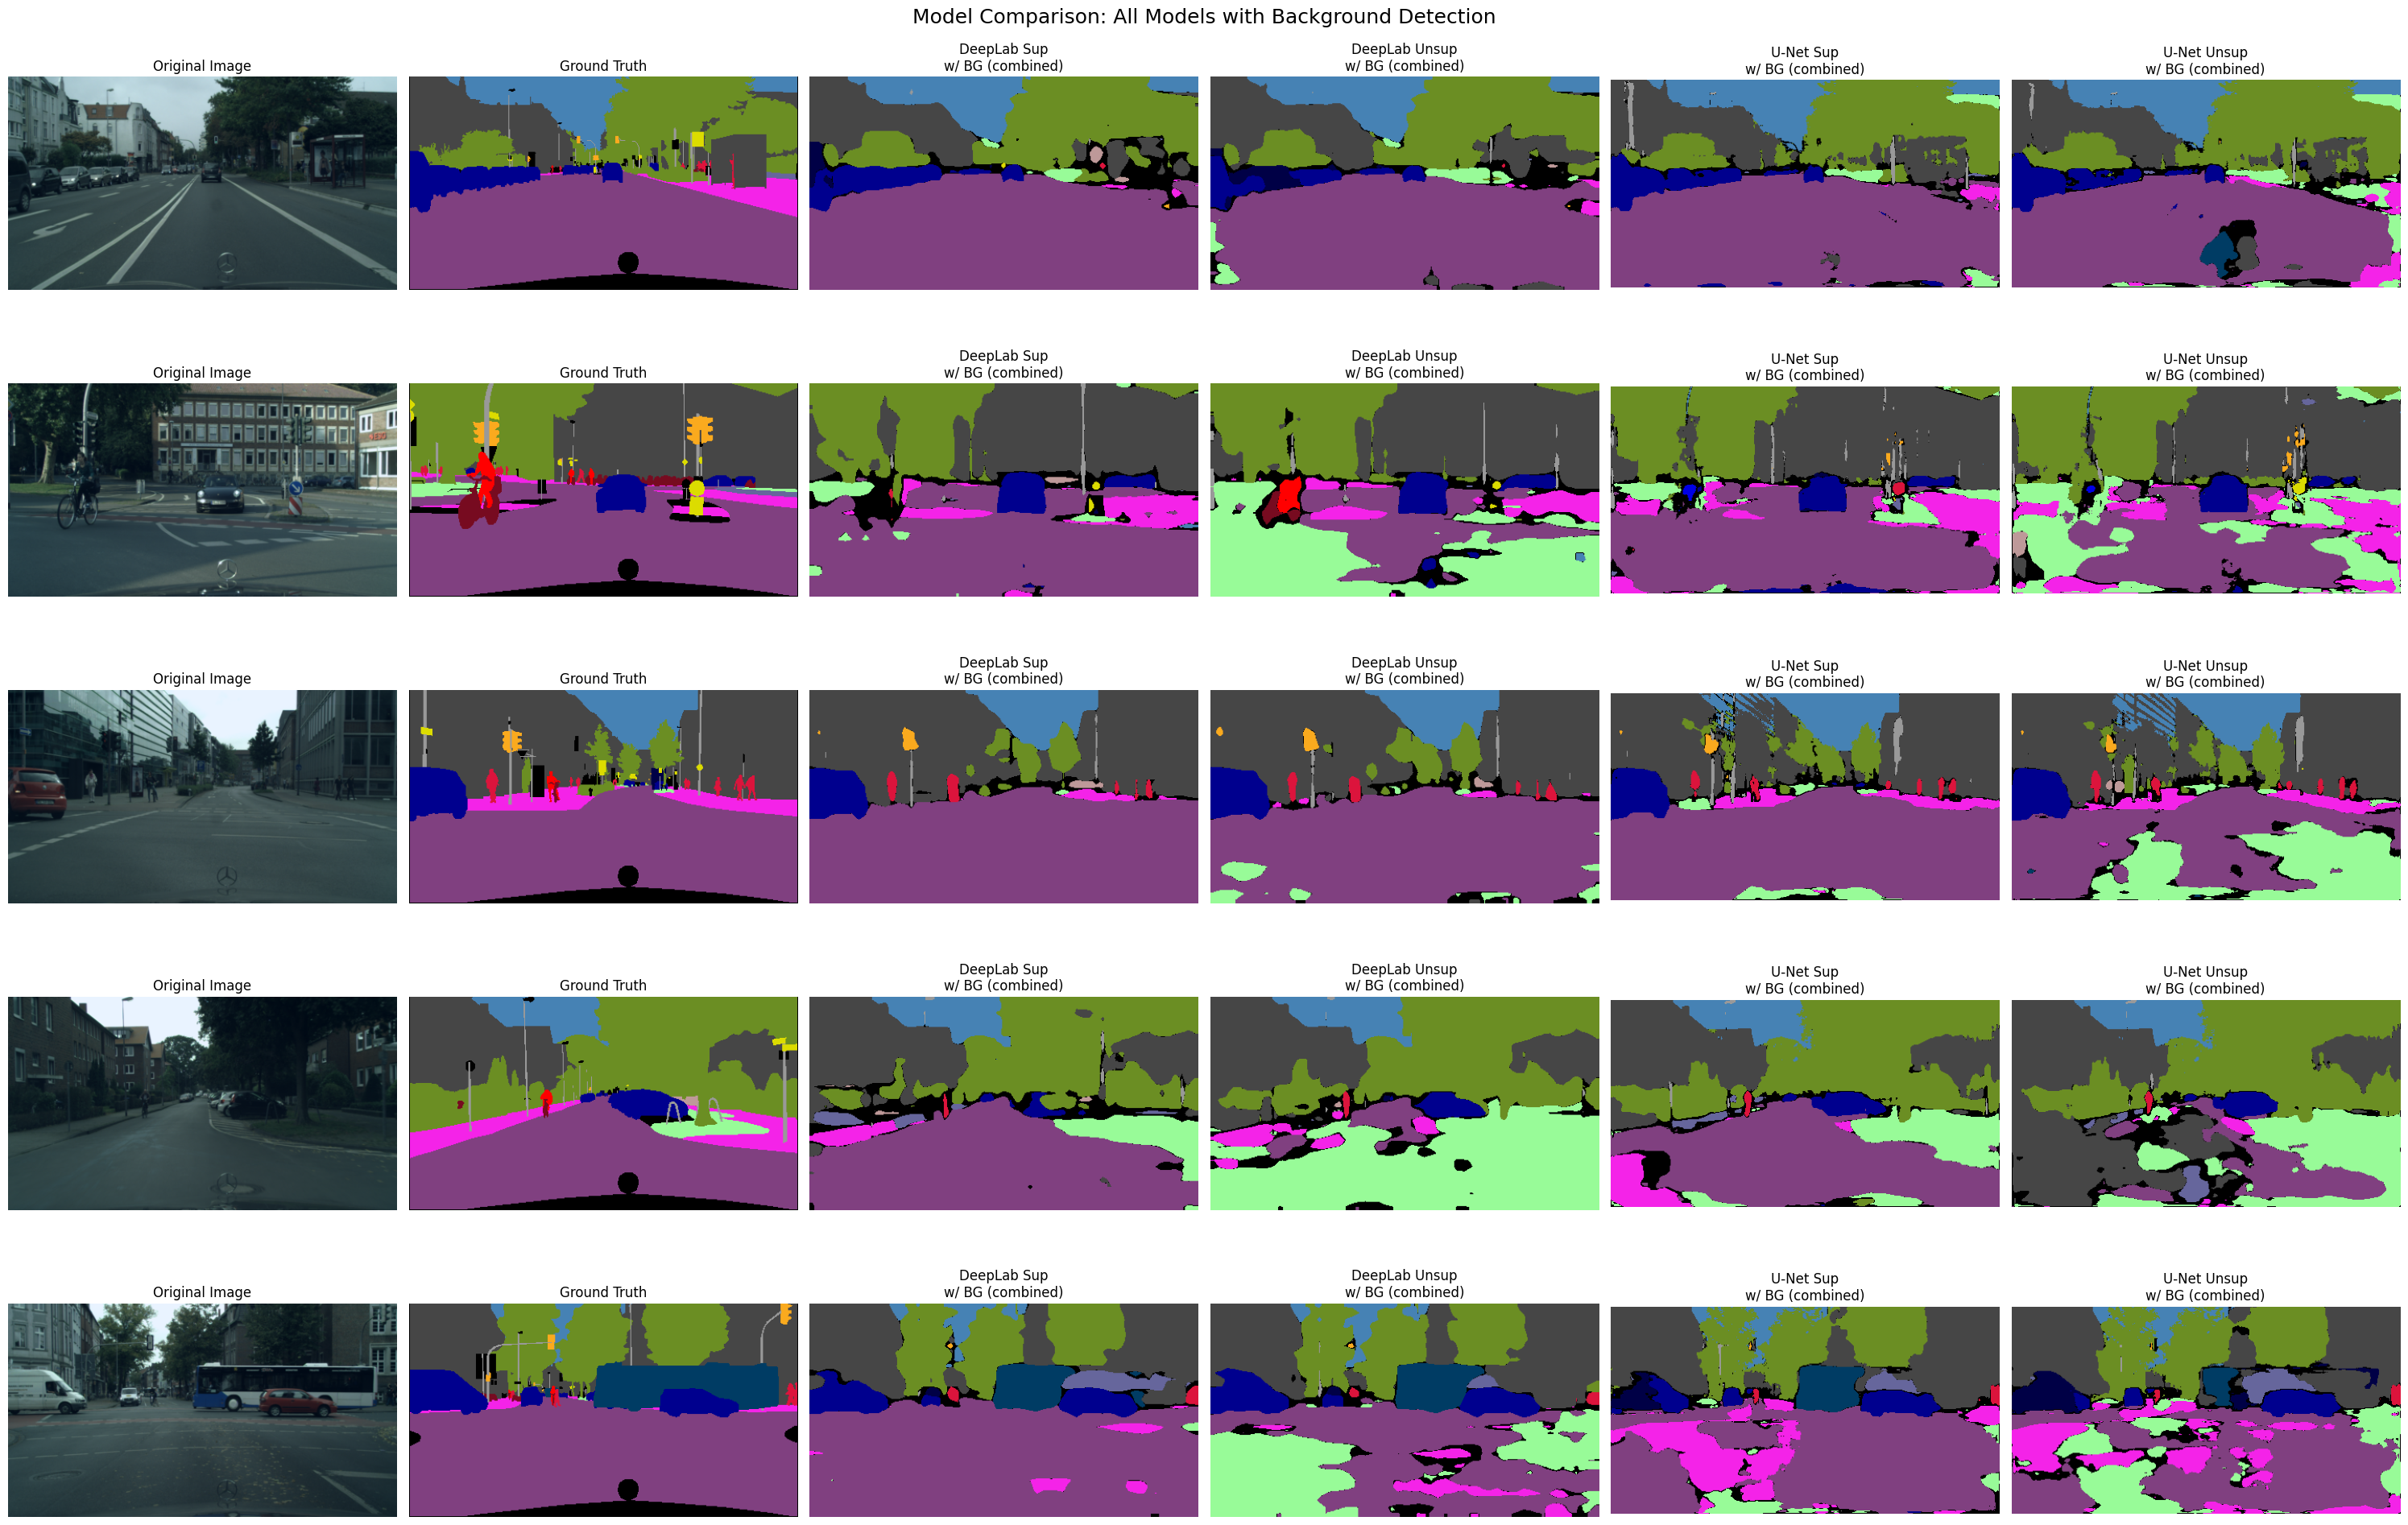

Input sizes - DeepLab: torch.Size([256, 466]) | U-Net: torch.Size([256, 480]) (H x W)
Background detection method: combined
Confidence threshold: 0.5
Entropy threshold: 1.0


In [11]:
# Call the visualization comparison function with all 4 models
visualize_deeplab_unet_comparison(
    deeplab_sup_model=model_deeplab_sup,
    deeplab_unsup_model=model_deeplab_unsup, 
    unet_sup_model=model_unet_sup,
    unet_unsup_model=model_unet_unsup,
    deeplab_dataloader=deeplab_real_val_dataloader,
    unet_dataloader=unet_real_val_dataloader,
    num_samples=5,
    start_idx=0,
    deterministic=True,
    confidence_threshold=0.5,
    entropy_threshold=1.0,
    method='combined'
)